In [1]:
# Run in a Colab cell
!pip install prophet plotly scikit-learn pandas matplotlib


In [2]:
import pandas as pd

# Corrected: Using 'mock_kaggle.csv' as found after unzipping
df = pd.read_csv('/content/mock_kaggle.csv')
df.head()
df.info()
df['data'] = pd.to_datetime(df['data']) # Changed 'date' to 'data' in previous turn
df = df.sort_values('data').reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [3]:
# Convert date column to datetime
df['data'] = pd.to_datetime(df['data'], errors='coerce')

# Check how many invalid dates (if any)
bad_dates = df['data'].isna().sum()
print("Invalid date rows:", bad_dates)

# If invalid dates > 0, inspect them:
if bad_dates > 0:
    display(df[df['data'].isna()].head())

# Drop rows with invalid dates (if any)
df = df.dropna(subset=['data']).reset_index(drop=True)

# Ensure venda is numeric
df['venda'] = pd.to_numeric(df['venda'], errors='coerce')
print("Missing sales:", df['venda'].isna().sum())

# Fill or drop missing sales (simple approach: forward fill then drop remaining)
df['venda'] = df['venda'].fillna(method='ffill').fillna(method='bfill')
df = df.dropna(subset=['venda']).reset_index(drop=True)

# Sort by date
df = df.sort_values('data').reset_index(drop=True)
display(df.head())


Invalid date rows: 0
Missing sales: 0


/tmp/ipython-input-907823216.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['venda'] = df['venda'].fillna(method='ffill').fillna(method='bfill')


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


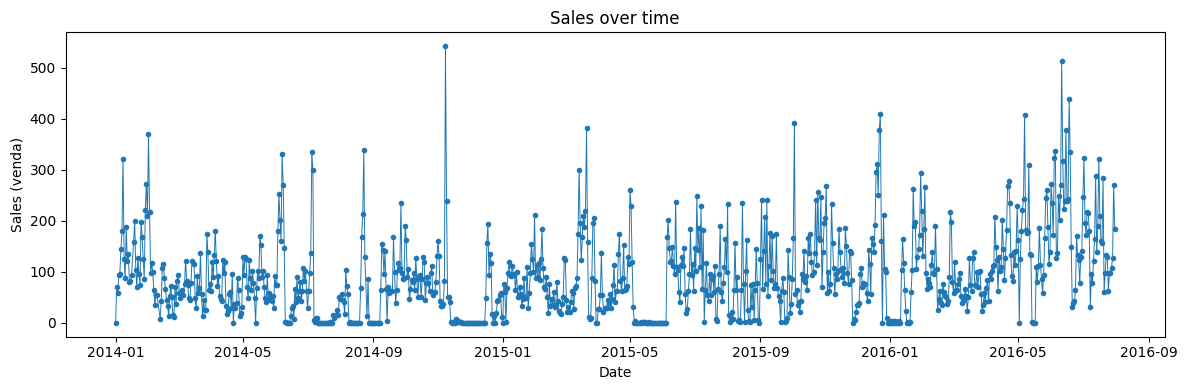

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(df['data'], df['venda'], marker='.', linewidth=0.7)
plt.title('Sales over time')
plt.xlabel('Date')
plt.ylabel('Sales (venda)')
plt.tight_layout();


In [5]:
ts = df[['data','venda']].rename(columns={'data':'ds','venda':'y'})
ts = ts.reset_index(drop=True)

# choose test period length (e.g., last 90 days). You can reduce to 30.
test_days = 90

train = ts[:-test_days].reset_index(drop=True)
test = ts[-test_days:].reset_index(drop=True)

print("Train rows:", len(train), "Test rows:", len(test))

Train rows: 847 Test rows: 90


In [6]:
# Uninstall prophet and cmdstanpy, then reinstall prophet to ensure compatibility
!pip uninstall prophet cmdstanpy -y
!pip install prophet --no-cache-dir

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 160.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 297.2 MB/s eta 0:00:00


In [7]:
# This patch is no longer strictly needed if Prophet is updated to a compatible version
# but keeping it won't hurt.
import numpy as np
if not hasattr(np, 'float'):
    np.float = np.float64

In [8]:
from prophet import Prophet

In [9]:
m = Prophet(
    daily_seasonality=True,    # data is daily
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Fit
m.fit(train)

In [10]:
# periods = length of test + extra future days you want to forecast
periods = test_days  # predict for test period length; change if you want further
future = m.make_future_dataframe(periods=periods)
forecast = m.predict(future)

# Show important columns
display(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10))


,ds,yhat,yhat_lower,yhat_upper
927,2016-07-22,86.669692,1.245818,162.862075
928,2016-07-23,132.372444,53.383305,214.806623
929,2016-07-24,89.912780,10.474707,166.705641
930,2016-07-25,64.484261,-17.551958,151.658050
931,2016-07-26,61.205511,-22.007947,143.971957
932,2016-07-27,79.067451,-3.529291,156.220256
933,2016-07-28,67.606641,-11.839451,144.452443
934,2016-07-29,79.118383,-2.082917,158.987356
935,2016-07-30,126.309599,45.668528,212.105158
936,2016-07-31,85.407979,5.750034,171.560088


In [11]:
import plotly.express as px

# merge forecast with actuals (for comparison)
pred = forecast[['ds','yhat']].set_index('ds').join(ts.set_index('ds')['y'].rename('actual'), how='left').reset_index()

fig = px.line(pred, x='ds', y=['actual','yhat'], labels={'value':'Sales','ds':'Date'}, title='Actual vs Predicted Sales')
fig.update_layout(legend_title_text='Series')
fig.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Align forecasts with test dates
fc_idx = forecast.set_index('ds').loc[test['ds']]

y_true = test['y'].values
y_pred = fc_idx['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 89.98
RMSE: 112.57


In [13]:
# Save final future forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv('forecast_output.csv', index=False)

print("Saved forecast_output.csv")


Saved forecast_output.csv


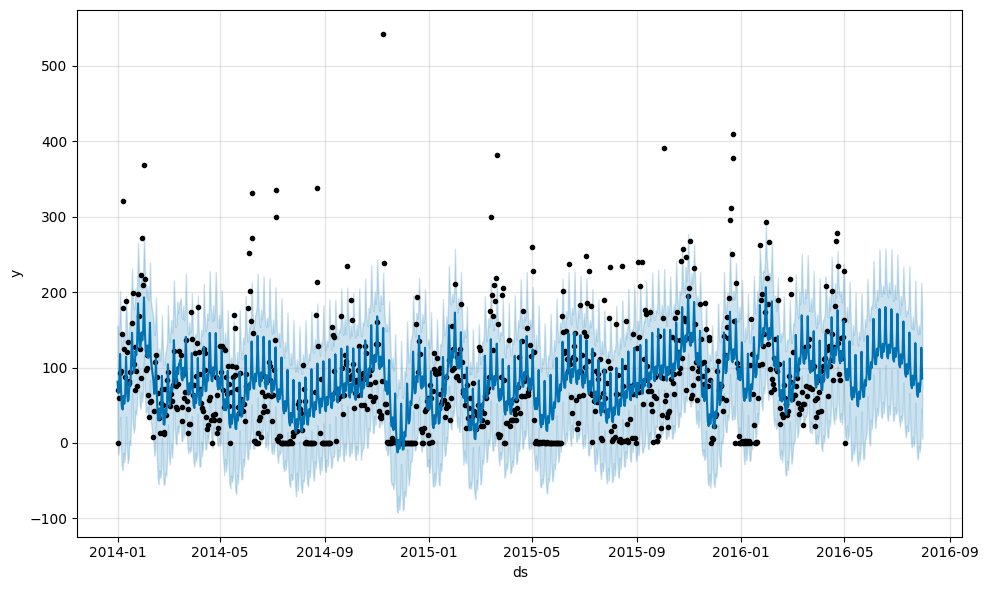

In [14]:
fig1 = m.plot(forecast)


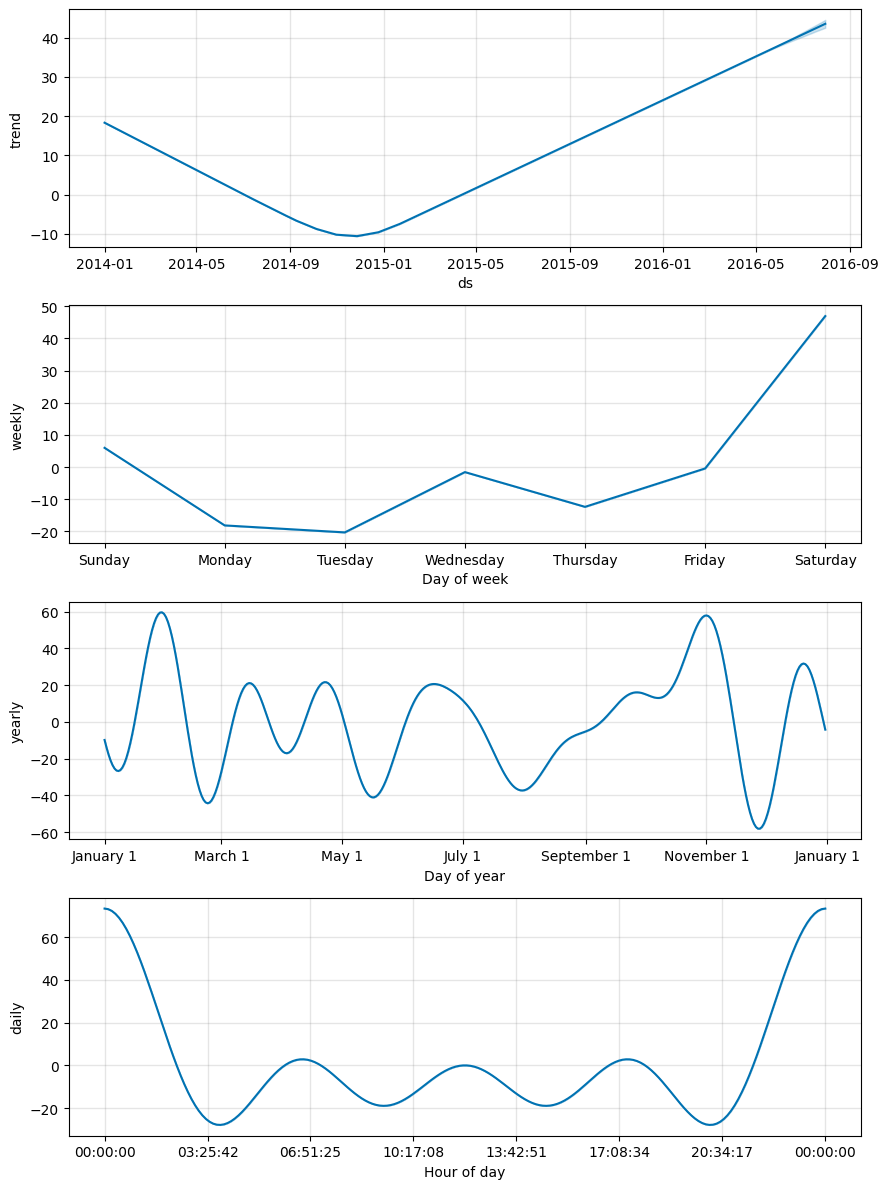

In [15]:
fig2 = m.plot_components(forecast)
